# Fashion-MNIST classification

In [1]:
import time

import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
test_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)

In [4]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [5]:
# Print some kind of data sets summary
print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None


In [6]:
train_x = np.array(train_set.train_data)
train_y = np.array(train_set.train_labels)

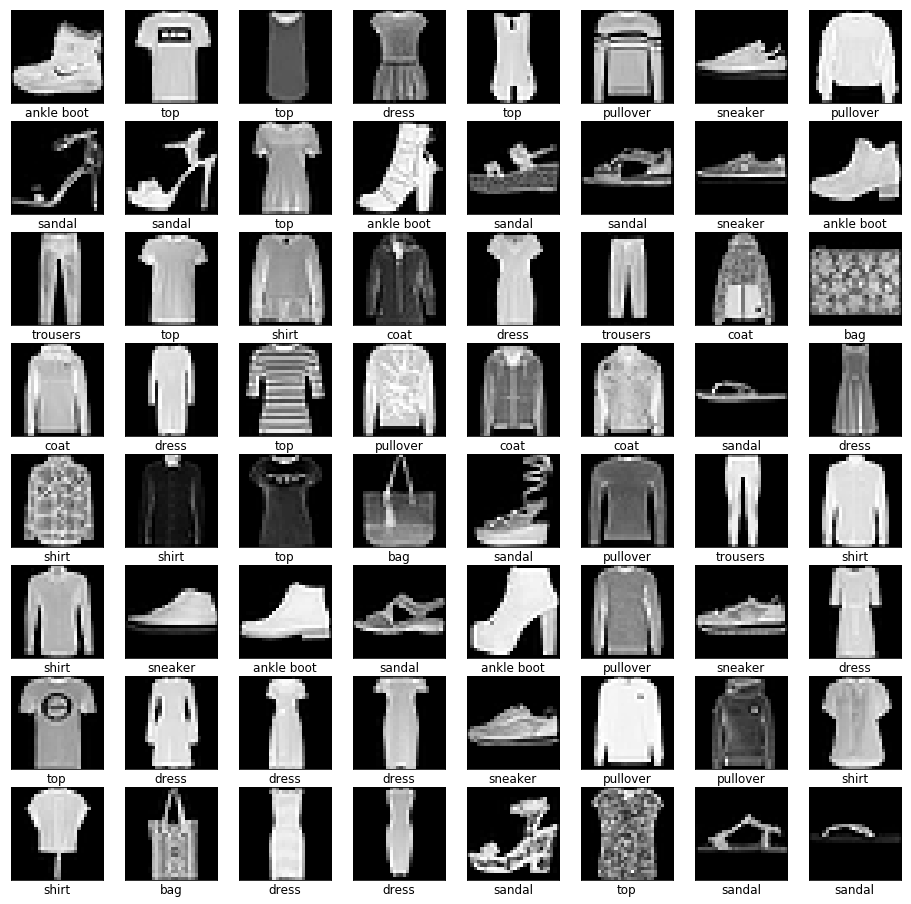

In [7]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xlabel(labels[train_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

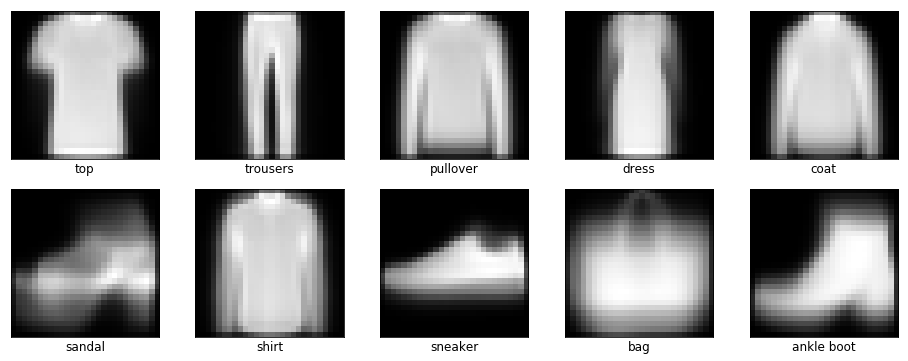

In [8]:
centroids = [(labels[i], np.mean(train_x[train_y == i], axis=0)) for i, _ in enumerate(labels)]

plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

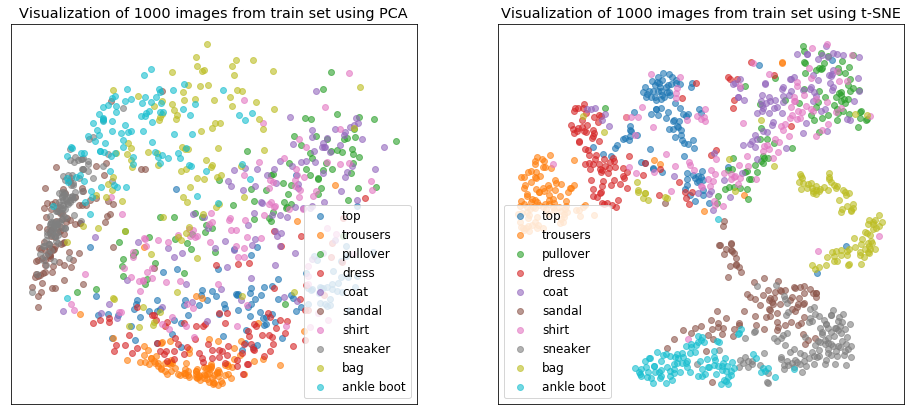

In [9]:
plt.figure(figsize=(16, 7))
for i, (algorithm_name, algorithm) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x = algorithm.fit_transform(train_x[:1000].reshape(-1, 784))
    y = train_y[:1000]
    data = [(labels[i], x[y == i]) for i, _ in enumerate(labels)]
    
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'Visualization of 1000 images from train set using {algorithm_name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
data_set = torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000))),
    batch_size=250, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000, 60000))),
    batch_size=250)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250)

In [11]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_loader, val_loader, epochs):
        self.to(self.device)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for i in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for data, target in train_loader:
                self.optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss_ = self.loss(output, target)
                loss += float(loss_) * len(data)
                acc += int((output.argmax(dim=1) == target).sum())
                loss_.backward()
                self.optimizer.step()
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self.evaluate(val_loader)
            history['epoch'].append(i)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            duration = time.time() - start_time
            print(
                f'[{i:2}/50] {duration:4.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for data, target in data_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self(data)
            loss += float(self.loss(output, target)) * len(data)
            acc += int((output.argmax(dim=1) == target).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

In [12]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'Visualization of {name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()

In [13]:
class Model(Classifier):

    def __init__(self):
        super(Model, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1)
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [14]:
model = Model()

In [15]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50]  4.1s - loss: 0.7439 - acc: 0.7408 - val_loss: 0.4915 - val_acc: 0.8276
[ 2/50]  4.0s - loss: 0.5137 - acc: 0.8186 - val_loss: 0.4298 - val_acc: 0.8472
[ 3/50]  4.0s - loss: 0.4653 - acc: 0.8349 - val_loss: 0.3977 - val_acc: 0.8534
[ 4/50]  4.0s - loss: 0.4376 - acc: 0.8422 - val_loss: 0.3809 - val_acc: 0.8576
[ 5/50]  4.0s - loss: 0.4153 - acc: 0.8496 - val_loss: 0.3666 - val_acc: 0.8658
[ 6/50]  3.9s - loss: 0.4028 - acc: 0.8545 - val_loss: 0.3626 - val_acc: 0.8662
[ 7/50]  3.9s - loss: 0.3926 - acc: 0.8588 - val_loss: 0.3499 - val_acc: 0.8744
[ 8/50]  3.9s - loss: 0.3832 - acc: 0.8608 - val_loss: 0.3429 - val_acc: 0.8756
[ 9/50]  3.9s - loss: 0.3746 - acc: 0.8627 - val_loss: 0.3346 - val_acc: 0.8734
[10/50]  3.9s - loss: 0.3695 - acc: 0.8653 - val_loss: 0.3277 - val_acc: 0.8760
[11/50]  3.9s - loss: 0.3590 - acc: 0.8681 - val_loss: 0.3223 - val_acc: 0.8794
[12/50]  3.9s - loss: 0.3562 - acc: 0.8690 - val_loss: 0.3235 - val_acc: 0.8768
[13/50]  3.9s - loss: 0.3508 - acc: 0.87

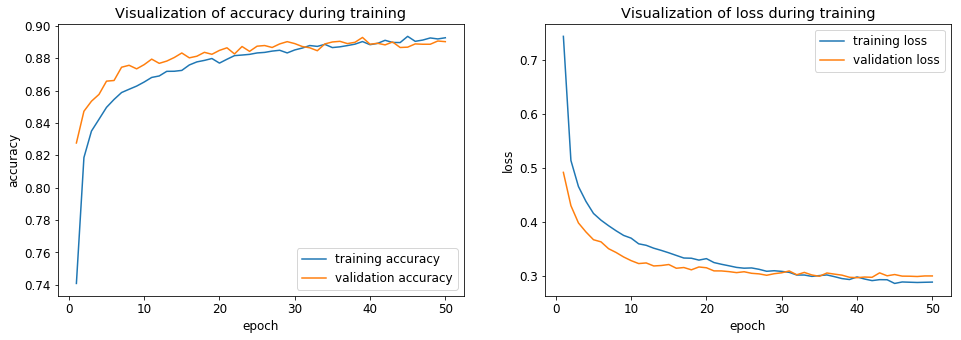

In [16]:
plot_history(history)

In [17]:
print(f'Train set accuracy:      {model.evaluate(train_loader)[1]:.4f}')
print(f'Validation set accuracy: {model.evaluate(val_loader)[1]:.4f}')
print(f'Test set accuracy:       {model.evaluate(test_loader)[1]:.4f}')

Train set accuracy:      0.9224
Validation set accuracy: 0.8902
Test set accuracy:       0.8873


In [18]:
class Model(Classifier):

    def __init__(self):
        super(Model, self).__init__()
        self.conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.dense_layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.dense_layers:
            x = layer(x)
        return x

In [19]:
model = Model()

In [20]:
history = model.fit(train_loader, val_loader, epochs=50)

[ 1/50]  4.8s - loss: 0.9514 - acc: 0.6489 - val_loss: 0.5675 - val_acc: 0.7706
[ 2/50]  4.7s - loss: 0.6178 - acc: 0.7677 - val_loss: 0.4745 - val_acc: 0.8146
[ 3/50]  4.8s - loss: 0.5403 - acc: 0.8012 - val_loss: 0.4432 - val_acc: 0.8406
[ 4/50]  4.8s - loss: 0.4836 - acc: 0.8245 - val_loss: 0.3901 - val_acc: 0.8526
[ 5/50]  4.8s - loss: 0.4462 - acc: 0.8367 - val_loss: 0.3574 - val_acc: 0.8636
[ 6/50]  4.8s - loss: 0.4153 - acc: 0.8493 - val_loss: 0.3406 - val_acc: 0.8696
[ 7/50]  4.9s - loss: 0.3943 - acc: 0.8573 - val_loss: 0.3218 - val_acc: 0.8772
[ 8/50]  4.8s - loss: 0.3774 - acc: 0.8636 - val_loss: 0.3152 - val_acc: 0.8834
[ 9/50]  4.7s - loss: 0.3616 - acc: 0.8684 - val_loss: 0.3098 - val_acc: 0.8782
[10/50]  4.8s - loss: 0.3472 - acc: 0.8754 - val_loss: 0.2995 - val_acc: 0.8894
[11/50]  4.9s - loss: 0.3409 - acc: 0.8770 - val_loss: 0.2869 - val_acc: 0.8904
[12/50]  5.0s - loss: 0.3298 - acc: 0.8811 - val_loss: 0.2894 - val_acc: 0.8918
[13/50]  4.9s - loss: 0.3205 - acc: 0.88

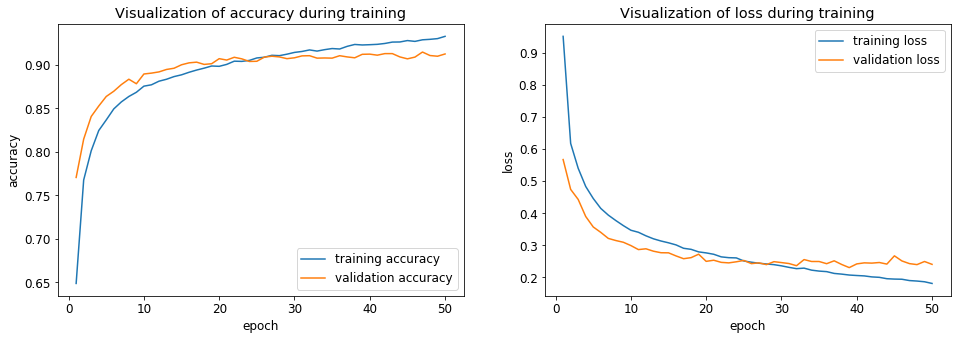

In [21]:
plot_history(history)

In [22]:
print(f'Train set accuracy:      {model.evaluate(train_loader)[1]:.4f}')
print(f'Validation set accuracy: {model.evaluate(val_loader)[1]:.4f}')
print(f'Test set accuracy:       {model.evaluate(test_loader)[1]:.4f}')

Train set accuracy:      0.9544
Validation set accuracy: 0.9124
Test set accuracy:       0.9061
